# Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 150)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Glimpse of Data

In [ ]:
# Read data
path = '../input/walmart-recruiting-store-sales-forecasting/'

features = pd.read_csv(f'{path}features.csv.zip')
train = pd.read_csv(f'{path}train.csv.zip')
test = pd.read_csv(f'{path}test.csv.zip')
stores = pd.read_csv(f'{path}stores.csv')
sample_submission = pd.read_csv(f'{path}sampleSubmission.csv.zip')

dataset columns values

In [ ]:
pd.DataFrame(features.dtypes, columns=['Type']).T

In [ ]:
pd.DataFrame(train.dtypes, columns=['Type']).T

In [ ]:
pd.DataFrame(stores.dtypes, columns=['Type']).T

### dataset head

In [ ]:
features.head()

In [ ]:
%%time
features.describe()

In [ ]:
train.head()

In [ ]:
%%time
train.describe()

In [ ]:
stores.head()

In [ ]:
%%time
stores.describe()

Pre-Processing

We'll merge data: features and stores have a commom key 'Stores' we can create a new data using the keys 'Store', 'Dept' and 'IsHoliday'. The data will be loaded into 'dataset, dataset_test'.

In [ ]:
dataset = train.merge(stores, how='left').merge(features, how='left')
dataset.shape

In [ ]:
dataset.head() 

In [ ]:
dataset_test = test.merge(stores, how='left').merge(features, how='left')
dataset_test.shape

In [ ]:

dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Week'] = pd.to_datetime(dataset['Date']).dt.week
dataset['DayOfTheWeek'] = dataset['Date'].dt.dayofweek
dataset['Day'] = pd.to_datetime(dataset['Date']).dt.day
dataset.replace({'A': 1, 'B': 2,'C':3},inplace=True)

dataset_test['Date'] = pd.to_datetime(dataset_test['Date'])
dataset_test['Year'] = pd.to_datetime(dataset_test['Date']).dt.year
dataset_test['Month'] = pd.to_datetime(dataset_test['Date']).dt.month
dataset_test['Week'] = pd.to_datetime(dataset_test['Date']).dt.week
dataset_test['DayOfTheWeek'] = dataset_test['Date'].dt.dayofweek

dataset_test['Day'] = pd.to_datetime(dataset_test['Date']).dt.day
dataset_test.replace({'A': 1, 'B': 2,'C':3},inplace=True)

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data.

### Examine Missing Values
Next we can look at the number and percentage of missing values in each column

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
%%time
missing_data(dataset)

Handling missing values
> Package called missingno (https://github.com/ResidentMario/missingno) !pip install quilt

Nullity Matrix. The msno.matrix nullity matrix is a data-dense display which lets you quickly visually analyse data completion.


In [ ]:
import missingno as msno
msno.matrix(dataset)

Heatmap. The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

In [ ]:
%%time
a = msno.heatmap(dataset, sort='ascending')
a

### Column Types

Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either [discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). object columns contain strings and are [categorical features](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data).

In [ ]:
# Number of each type of column
dataset.dtypes.value_counts()

Number of unique classes in each object column

In [ ]:
# Number of unique classes in each object column
dataset.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

# Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent are](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf):

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [ ]:
%%time
corrs = dataset.corr()
plt.figure(figsize = (20, 8))
# Heatmap of correlations
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.8)
plt.title('Clustermap');

We calculate now the correlations between the features in dataset. The following table shows the first 15 the least correlated features.

In [ ]:
%%time
features = dataset.columns.values
corrs_ = dataset[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs_ = corrs_[corrs_['level_0'] != corrs_['level_1']]
corrs_.head(15).T

Let's look to the top 15 most correlated features, besides the same feature pairs.

In [ ]:
corrs_.tail(15).T

# Feature Selection

Find the optimal feature subset using an evaluation measure. The choice of evaluation metric distinguish the three main strategies of feature selection algorithms: the wrapper strategy, the filter strategy, and the embedded strategy

Filter methods:

- information gain
- chi-square test
- correlation coefficient
- variance threshold

Wrapper methods:

- recursive feature elimination
- sequential feature selection algorithms

Embedded methods:

- L1 (LASSO) regularization
- decision tree

In our case, we remove some useless, redundant variables. We will use three methods for feature selection: Remove collinear features, remove features with greater than a threshold percentage of missing values, keep only the most relevant features using feature importances from a model

### Remove Collinear Variables

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set.

guidelines:[Drop Highly Correlated Features](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/)

In [ ]:
# Threshold for removing correlated variables
threshold = 0.92

# Absolute value correlation matrix
corr_matrix = dataset.corr().abs()
corr_matrix.head()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

Select columns with correlations above threshold

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
dataset = dataset.drop(columns = to_drop)
print('Data shape: ', dataset.shape)
print('Size of the data', dataset.shape)

Applying this on the entire dataset results in 64 collinear features removed.

In [ ]:
to_drop

### Remove Missing Values

In this implementation, if any columns have greater than 85% missing values, they will be removed.

guidelines:[LightGBM Advanced Topics](https://github.com/Microsoft/LightGBM/blob/master/docs/Advanced-Topics.rst)

In [ ]:
## Dataset missing values (in percent)
dataset_missing = (dataset.isnull().sum() / len(dataset)).sort_values(ascending = False)
dataset_missing.head()

In [ ]:
# Identify missing values above threshold
dataset_missing_ = dataset_missing.index[dataset_missing > 0.90]

all_missing = list(set(dataset_missing_))
print('There are %d columns with more than 90%% missing values' % len(all_missing))
dataset = dataset.drop(columns = all_missing)
print('Data shape: ', dataset.shape)

# Feature Selection through Feature Importances

> We want to see mos important features

In [ ]:
import xgboost as xgb

train_y = dataset['Weekly_Sales']
train_X = dataset.drop(["Weekly_Sales", "Date"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [ ]:
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()

# Outlier Analysis

The day of the week with Monday=0, Sunday=6.

In [ ]:
def box_plot_dist_var(var):
#     var = 'DayOfTheWeek'
    data_ = pd.concat([dataset['Weekly_Sales'], dataset[var]], axis=1)
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var, y="Weekly_Sales", data=data_)
    plt.xticks(rotation=90);

box_plot_dist_var("DayOfTheWeek")        
box_plot_dist_var("Day")    

Final general, some final days a month have hig week sales value

In [ ]:
def scatter_plot_var(var):
    data = pd.concat([dataset['Weekly_Sales'],dataset[var] ], axis=1)
    data.plot.scatter(x=var, y='Weekly_Sales')
scatter_plot_var("Unemployment")
scatter_plot_var("CPI")
scatter_plot_var("Temperature")
scatter_plot_var("Dept")
scatter_plot_var("Type")
    


The type 2 have more extreme values,as well as Dept 70, Temperature 50-60.

So, we'll define the extreme values for week sales>=4000000 and see some distributions, peaks in time series.


In [ ]:


d_low = dataset[dataset['Weekly_Sales'] < 300000]
d_high = dataset[dataset['Weekly_Sales'] >= 300000]
dataset ['Weekly_Sales_low_high'] = np.where(  dataset['Weekly_Sales']<300000, 0, 1)

In [ ]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['Weekly_Sales_low_high'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'inline', 1:'Weekly_Sales Low High'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    total = df.shape[0] # arbitrary
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 
    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='Weekly_Sales_low_high', data=df, order=tmp[col].values)
    plt.legend(title='Weekly_Sales Low High', loc='best', labels=['no', 'yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Weekly_Sales Low High', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Weekly_Sales_low_high", fontsize=16)

    g1.set_title(f"{col} by Target(Weekly_Sales_low_high)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

### Ploting columns with few unique values

In [ ]:
for col in ['Type']:
    dataset[col] = dataset[col].fillna('NaN')
    cat_feat_ploting(dataset, col)

In [ ]:
def plot_target_dist(df):
    total = len(df)
    g = sns.countplot(x='Weekly_Sales_low_high', data=df, )
    g.set_title("Weekly Sales  Distribution \n# 0: Low | 1: High #", fontsize=22)
    g.set_ylabel('Count', fontsize=18)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=15) 

def ts_target_lowhigh(df, roh):
    plt.figure(figsize=(16,6))
    df_features = df.sort_index()
    df_low = df_features[df_features['Weekly_Sales'] < roh]['Weekly_Sales']
    df_high = df_features[df_features['Weekly_Sales'] >= roh]['Weekly_Sales']
    plt.plot(df_features['Weekly_Sales'].index, df_features['Weekly_Sales'].fillna(1), c='gray', alpha=0.4)
    plt.scatter(df_low.index, df_low.values, label='LOW', s=10)
    plt.scatter(df_high.index, df_high.values, label='HIGH', c='red', s=10)
    plt.margins(x=0.01,y=0.2)
    plt.title('Weekly_Sales')
    plt.xlabel('Date')
    plt.legend()
    plt.show()


In [ ]:
plot_target_dist(dataset)     
ts_target_lowhigh(dataset, 300000)  

We see some a

In [ ]:
!pip install change_finder

In [ ]:
# coding: utf-8
import change_finder 

def changeFinder(data, r, smooth):
    #CHANGEFINDER PACKAGE
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(13,8))
    f.subplots_adjust(hspace=0.4)
    ax1.plot(data)
    ax1.set_title("data count")
    #Initiate changefinder function
    cf = change_finder.ChangeFinder(r=r, k=2, T=smooth, R=2)
    scores = [cf.update(p) for p in data]
    ax2.plot(scores)
    ax2.set_title("Anomaly Score for week")
    plt.show()
    return scores

In [ ]:
datacf = dataset.Weekly_Sales.values
dataplot1 = changeFinder(datacf, r=0.02, smooth=30)    

### Identifying Week Sales Peaks with Change Finger

In [ ]:
dataSF = np.array(dataplot1)
from scipy import stats
describedataSF = stats.describe(dataSF)
describedataSF

In [ ]:
qt25 = np.percentile(dataSF, 25)  # Q1
qt50 = np.percentile(dataSF, 50)  # Q2
qt60 = np.percentile(dataSF, 60)  # Q31
qt75 = np.percentile(dataSF, 75)  # Q3
qt95 = np.percentile(dataSF, 95)

qt75_ws = np.percentile(datacf, 75)
qt95_ws = np.percentile(datacf, 95)

In [ ]:
dfSF = pd.DataFrame(dataSF, columns=['Score_CF'])
dfSF.head()

In [ ]:
plt.figure(figsize=(16,6))
df_high_data_ = dfSF[dfSF <= qt75]
df_high_score_ = dfSF[dfSF > qt75]
plt.plot(dfSF.index, dfSF.Score_CF.fillna(1), c='gray', alpha=0.4)
plt.scatter(df_high_data_.index, df_high_data_.values, label='LOW', s=10)
plt.scatter(df_high_score_.index, df_high_score_.values, label='HIGH', c='red', s=10)
plt.margins(x=0.01,y=0.2)
plt.title('Anomaly Score ')
plt.ylabel('Score')
plt.xlabel('Data Count')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
df_features = dataset.sort_index()
df_high_data = df_features[df_features['Weekly_Sales'] < qt75_ws]['Weekly_Sales']
df_high_score = df_features[df_features['Weekly_Sales'] >= qt75_ws]['Weekly_Sales']
plt.plot(df_features['Weekly_Sales'].index, df_features['Weekly_Sales'].fillna(1), c='gray', alpha=0.4)
plt.scatter(df_high_data.index, df_high_data.values, label='LOW', s=10)
plt.scatter(df_high_score.index, df_high_score.values, label='HIGH', c='red', s=10)
plt.margins(x=0.01,y=0.2)
plt.title('Weekly Sales Time Series ')
plt.xlabel('Date')
plt.legend()
plt.show()

Work in progress

# Visualizations

### plot distribution curves for train and test data

In [ ]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(dataset[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(dataset_test[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

In [ ]:
plot_dist_col('Temperature')

In [ ]:
plot_dist_col('CPI')

In [ ]:
plot_dist_col('Size')

In [ ]:
plot_dist_col('Fuel_Price')

The Fuel Price for train, test have diferrent distribuctions.

In [ ]:
plot_dist_col('MarkDown1')

In [ ]:
plot_dist_col('MarkDown2')

In [ ]:
plot_dist_col('MarkDown3')

In [ ]:
plot_dist_col('MarkDown4')

In [ ]:
plot_dist_col('MarkDown5')

### Plot peaks sales for each Dept.
> Remember Weekly_Sales_low_high have sales values > 30000.

In [ ]:
for i in range(len(dataset["Dept"].value_counts())):    
    plt.figure(figsize=(20,5))
    sns.lineplot(x="Month", y="Weekly_Sales_low_high", data=dataset[dataset["Dept"]==dataset["Dept"].value_counts().index[i]],hue="Year").set_title(dataset["Dept"].value_counts().index[i], fontsize=16)


Just Dept. 7 and  72 have extreme Week Sales for November, December, in the years 2009, 2010,2011, 2012.

# Label Encoding

In [ ]:
#fill in mean for floats
for c in dataset.columns:
    if dataset[c].dtype=='float16' or  dataset[c].dtype=='float32' or  dataset[c].dtype=='float64':
        dataset[c].fillna(dataset[c].mean())

#fill in -999 for categoricals
dataset = dataset.fillna(-999)
# Label Encoding
for f in dataset.columns:
    if dataset[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(dataset[f].values))
        dataset[f] = lbl.transform(list(dataset[f].values))
        
print('Labelling done.') 

In [ ]:
#fill in mean for floats
for c in dataset_test.columns:
    if dataset_test[c].dtype=='float16' or  dataset_test[c].dtype=='float32' or  dataset_test[c].dtype=='float64':
        dataset_test[c].fillna(dataset_test[c].mean())

#fill in -999 for categoricals
dataset_test = dataset_test.fillna(-999)
# Label Encoding
for f in dataset_test.columns:
    if dataset_test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(dataset_test[f].values))
        dataset_test[f] = lbl.transform(list(dataset_test[f].values))
        
print('Labelling done.') 

# Simple Single Series Analysis by Store

In [ ]:
dataset_ts = dataset.groupby(['Date','Store','Dept','CPI'])['Weekly_Sales'].sum().reset_index()
dataset_ts.shape

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts=dataset_ts.groupby(["Date"])["Weekly_Sales"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Weekly_Sales')
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.plot(ts);

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [ ]:
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (15,9)
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

Simple decomposition of time series.

In [ ]:
#Monthly growth
gouped_monthly = dataset.groupby('Month')['Weekly_Sales'].mean().T
# gouped_monthly
gouped_monthly.plot(kind='bar',title='Total Average Sales by Month',figsize=(10,5))
plt.legend(loc='best')
plt.show()

Sales by months - all Store

Time series forecast for store, STORE 1 example

In [ ]:
dataset_store = dataset.groupby(['Date','Store','Dept','CPI'])['Weekly_Sales'].sum().reset_index()
Store1 = dataset_store[dataset_store.Store.isin([1])]

In [ ]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
import scipy.stats as scs

X = Store1
size = int(len(X) * 0.90)
# limitCount = 100
train, test = X[0:size], X[size:len(X)]
history = [x for x in train.Weekly_Sales]

In [ ]:
# !pip install pyramid-arima
!pip install pmdarima

### Stationary TS

In [ ]:
def stationary_test(df):
    # https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
    from statsmodels.tsa.stattools import adfuller
    print(" > Is the data stationary ?")
    dftest = adfuller(df, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(df.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
stationary_test(Store1.Weekly_Sales)

# Auto Arima for Time Series Forecast


In [ ]:
### Auto Arima 30 days OOS
# building the model
import pmdarima as pm
from pmdarima import auto_arima
model_ar = auto_arima(train.Weekly_Sales, trace=True, error_action='ignore', suppress_warnings=True)
model_ar.fit(train.Weekly_Sales)

In [ ]:
forecast = model_ar.predict(n_periods=test.shape[0])

In [ ]:
fig= go.Figure(data=
               [go.Scatter(x= test["Date"],
                           y= test["Weekly_Sales"],
                           name= "original", 
                           showlegend=True,
                           marker=dict(color="blue"))])
fig.add_trace(
    go.Scatter(x= test["Date"],
               y=forecast,
               name= "fitted values",
               showlegend= True, 
               marker=dict(color="red")))
fig.update_layout(
    title="Fitted values",
    xaxis_title="Dates",
    yaxis_title="Sales",
    font=dict(
        family="Arial, monospace",
        size=14,
        color="#7f7f7f"
    ) )
fig.show()

The evaluation is based on Weighted Mean Absolute Error (WMAE), with a weight of 5 for Holiday Weeks and 1 otherwise


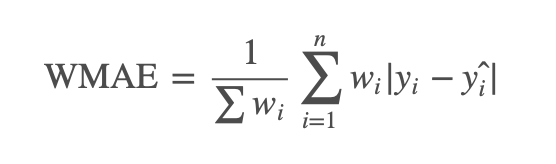


In [ ]:
def wmae(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [ ]:
%%time
# Validation

# all about rmsle https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

pred = []
for t in range(len(test)):
    model_ar_t = ARIMA(history, order=(5,0,1))
    model_fit = model_ar_t.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    pred.append(yhat)
    obs = test['Weekly_Sales'].iloc[t]
    history.append(obs)
    print('pred=%f, exp=%f' % (yhat, obs))

error_msetrain = mean_squared_error(test.Weekly_Sales, pred)
error_rmsle_train = rmsle(pred,error_msetrain)

print('Mean Squared Error: %.3f' % error_msetrain)
print('RMSLE: %.3f' % error_rmsle_train)

error_msetest = mean_squared_error(test.Weekly_Sales.values, pred)
error_rmsle_test = rmsle(pred,error_msetest)

print('Test MSE: %.3f' % error_msetest)
print('RMSLE: %.3f' % error_rmsle_test)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error_mape = mean_absolute_percentage_error(test.Weekly_Sales.values, np.array(pred))
print('Test MAPE: %.3f' % error_mape)

### Forecast Arima

In [ ]:
fig= go.Figure(data=
               [go.Scatter(x= test["Date"],
                           y= test["Weekly_Sales"],
                           name= "original", 
                           showlegend=True,
                           marker=dict(color="blue"))])
fig.add_trace(
    go.Scatter(x= test["Date"],
               y=pred,
               name= "fitted values",
               showlegend= True, 
               marker=dict(color="red")))
fig.update_layout(
    title="Fitted values",
    xaxis_title="Dates",
    yaxis_title="Sales",
    font=dict(
        family="Arial, monospace",
        size=14,
        color="#7f7f7f"
    )
)
fig.show()

### Out of Sample Arima

In [ ]:
forecastLimit=30 # 30 days oos
model_arima_oos = ARIMA(history, order=(5,0,3))
model_fit_oos = model_arima_oos.fit(disp=0)
output_oos = model_fit_oos.forecast(steps= forecastLimit)
predictions_oos = list(output_oos[0])

In [ ]:
fig= go.Figure(data=
               [go.Scatter(x= test["Date"],
                           y= test["Weekly_Sales"],
                           name= "original", 
                           showlegend=True,
                           marker=dict(color="blue"))])
fig.add_trace(
    go.Scatter(x= test["Date"],
               y=predictions_oos,
               name= "fitted values",
               showlegend= True, 
               marker=dict(color="red")))
fig.update_layout(
    title="Fitted values",
    xaxis_title="Dates",
    yaxis_title="Sales",
    font=dict(
        family="Arial, monospace",
        size=14,
        color="#7f7f7f"
    )
)
fig.show()

# Modeling

In [ ]:
split_date = '2012-06-01'
data_train = dataset.loc[dataset.Date <= split_date].copy()
data_test = dataset.loc[dataset.Date > split_date].copy()

In [ ]:
X_train, y_train = data_train[['Store', 'Size', 'Dept', 'Month', 'Year', 'IsHoliday', 'Temperature', 'Fuel_Price', 
          'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']], data_train['Weekly_Sales']

X_test, y_test = data_test[['Store', 'Size', 'Dept', 'Month', 'Year', 'IsHoliday', 'Temperature', 'Fuel_Price', 
          'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']], data_test['Weekly_Sales']

X_train.shape, y_train.shape, X_test.shape, y_test.shape


# Baseline Model

### XGBoost Model

In [ ]:
reg = xgb.XGBRegressor(n_estimators=500)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

In [ ]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(reg, height=0.9)

### Forecast on Test Set XGB Regressor

In [ ]:
data_test['Weekly_Sales_pred'] = reg.predict(X_test)
dataset_all = pd.concat([data_test, data_train], sort=True)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(y_true=data_test['Weekly_Sales'],
                   y_pred=data_test['Weekly_Sales_pred'])

In [ ]:
mean_absolute_error(y_true=data_test['Weekly_Sales'],
                   y_pred=data_test['Weekly_Sales_pred'])

In [ ]:
from statsmodels.tools.eval_measures import rmse
import datetime 
error=rmse(data_test['Weekly_Sales'],
                   data_test['Weekly_Sales_pred'])
error

In [ ]:
holiday_week_teste = data_train.IsHoliday.apply(lambda x: True if x else False)
wmae_xgb = wmae(data_test,data_test.Weekly_Sales, data_test.Weekly_Sales_pred)
wmae_xgb

In [ ]:
plt.scatter(data_test['Weekly_Sales_pred'], data_test['Weekly_Sales'], alpha = 0.05)
plt.xlabel("y predicted by XGB")
plt.ylabel("y true")
plt.title("y pred vs y true (XGB)")
plt.show()

### Forecast on Test Set Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=80, max_depth=35)
rf_reg.fit(X_train, y_train)

In [ ]:
data_test['Weekly_Sales_pred_rf_ref'] = rf_reg.predict(X_test)
dataset_all = pd.concat([data_test, data_train], sort=True)

mean_absolute_error(y_true=data_test['Weekly_Sales'],
                   y_pred=data_test['Weekly_Sales_pred_rf_ref'])

In [ ]:
error_=rmse(data_test['Weekly_Sales'],
                   data_test['Weekly_Sales_pred_rf_ref'])
error_

In [ ]:
wmae_rfreg = wmae(data_test,data_test.Weekly_Sales, data_test.Weekly_Sales_pred_rf_ref)
wmae_rfreg

In [ ]:
plt.scatter(data_test['Weekly_Sales_pred_rf_ref'], data_test['Weekly_Sales'], alpha = 0.05)
plt.xlabel("y predicted by Random Forest")
plt.ylabel("y true")
plt.title("y pred vs y true (Random Forest)")
plt.show()

### Baseline submission

In [ ]:
predicted_test = rf_reg.predict(dataset_test[['Store','Size','Dept','Month','Year','IsHoliday','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment']])

dataset_test['weeklySales'] = predicted_test
dataset_test['id'] = dataset_test['Store'].astype(str) + '_' +  dataset_test['Dept'].astype(str) + '_' +  dataset_test['Date'].astype(str)
dataset_test = dataset_test[['id', 'weeklySales']]
dataset_test = dataset_test.rename(columns={'id': 'Id', 'weeklySales': 'Weekly_Sales'})
dataset_test.head()

In [ ]:
dataset_test.to_csv('submission_baseline.csv', index=False)

# End notebook